# `nb05`: MCMC

In [30]:
import numpy as np
import matplotlib.pyplot as plt
import tqdm

# Metropolis-Hastings

In [31]:
def mh_sample(theta0, n, log_target, q, seed=0):
    np.random.seed(seed)
    
    theta_t = theta0
    thetas = []
    accepts = 0
    
    for i in tqdm.tqdm(range(n)):
        theta_prop = q(theta_t)
        u = np.random.rand()
        
        if np.log(u) < log_target(theta_prop) - log_target(theta_t):
            theta_t = theta_prop
            accepts += 1
        
        thetas.append(theta_t)
        
    return np.array(thetas), accepts / n

In [36]:
thetas, accept_ratio = mh_sample(0.0, 10000, 
                                 lambda theta: -np.abs(theta),  
                                 lambda theta_t: theta_t + np.random.randn())

print("Accept ratio =", accept_ratio)

100%|██████████| 10000/10000 [00:00<00:00, 307877.24it/s]

Accept ratio = 0.7106


In [37]:
thetas

array([0.        , 0.40015721, 0.40015721, ..., 0.26843115, 0.26843115,
       1.4485474 ])

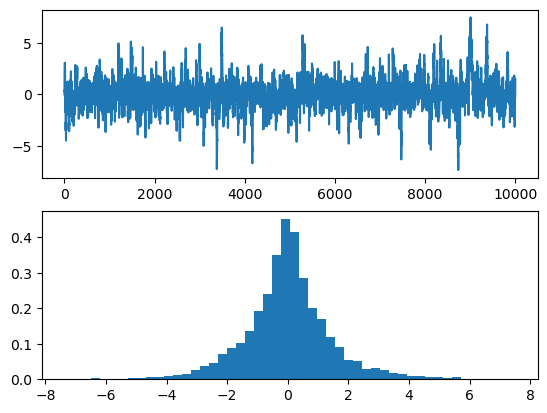

In [38]:
fig, ax = plt.subplots(2)

ax[0].plot(thetas)
ax[1].hist(thetas, bins=50, density=True)

plt.show()

## Proposals

100%|██████████| 10000/10000 [00:00<00:00, 164258.99it/s]


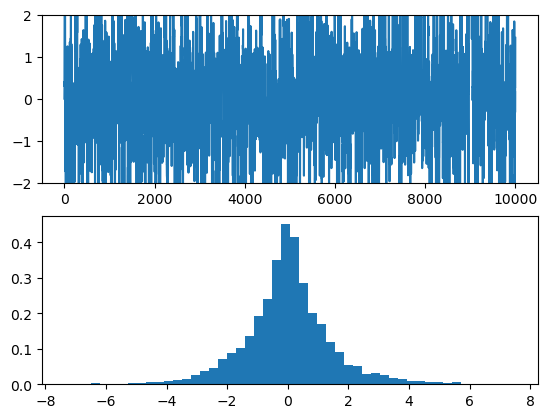

Accept ratio = 0.7106


In [49]:
# Narrow proposal
thetas, accept_ratio = mh_sample(0.0, 10000, 
                                 lambda theta: -np.abs(theta),
                                 lambda theta_t: theta_t + np.random.randn())

fig, ax = plt.subplots(2)

ax[0].plot(thetas)
ax[0].set(ylim=(-2, 2))
ax[1].hist(thetas, bins=50, density=True)

plt.show()

print("Accept ratio =", accept_ratio)

100%|██████████| 10000/10000 [00:00<00:00, 347532.81it/s]


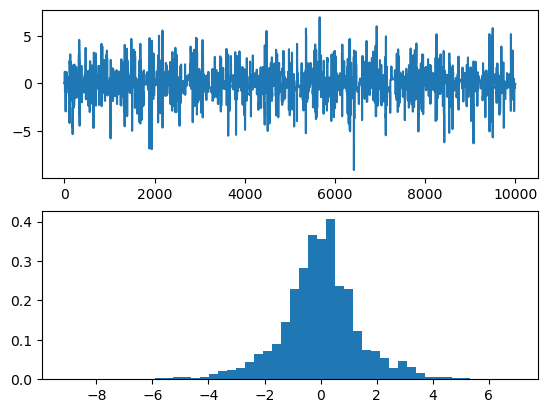

Accept ratio = 0.165


In [50]:
# Wide proposal
thetas, accept_ratio = mh_sample(0.0, 10000, 
                                 lambda theta: -np.abs(theta),
                                 lambda theta_t: theta_t + 10.0 * np.random.randn())

fig, ax = plt.subplots(2)

ax[0].plot(thetas)
ax[1].hist(thetas, bins=50, density=True)

plt.show()

print("Accept ratio =", accept_ratio)

<div class="alert alert-success">
    
**Exercise**. Repeat the execution above but for 1000 samples. What do you observe? 
    
</div>

  0%|          | 0/10000 [00:00<?, ?it/s]

100%|██████████| 10000/10000 [00:00<00:00, 171769.58it/s]


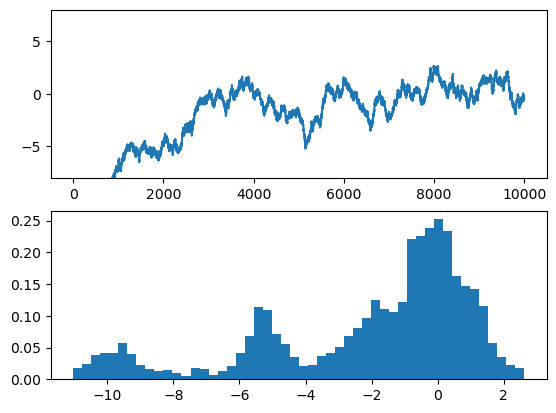

Accept ratio = 0.9644


In [59]:
thetas, accept_ratio = mh_sample(-10.0, 10000, 
                                 lambda theta: -np.abs(theta),
                                 lambda theta_t: theta_t + 0.1 * np.random.randn())

fig, ax = plt.subplots(2)

ax[0].plot(thetas)
ax[0].set(ylim=(-8, 8))
ax[1].hist(thetas, bins=50, density=True)

plt.show()

print("Accept ratio =", accept_ratio)

<div class="alert alert-success">
    
**Exercise**. Try with non-Gaussian proposal distribution.
    
</div>

In summary:
- Too narrow proposals lead to very high acceptance rates but persistent random walks that can seriously bias the sample. 
- Too wide proposals lead to very low acceptance rates and long sequences of identical states that can be seen as spikes in the histogram of the samples.

## Thining, Warm up

100%|██████████| 500000/500000 [00:01<00:00, 259716.66it/s]


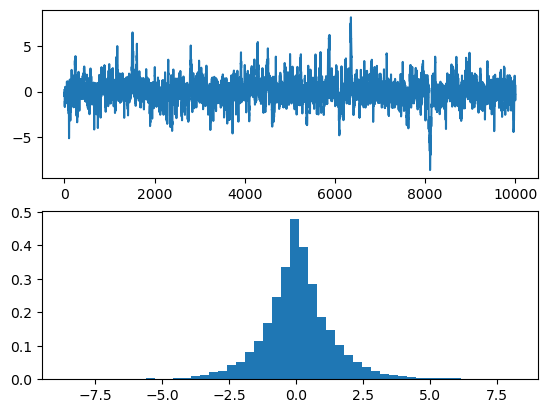

Accept ratio = 0.960988


In [60]:
# Thinning
thetas, accept_ratio = mh_sample(0.0, 10000*50,
                                 lambda theta: -np.abs(theta),
                                 lambda theta_t: theta_t + 0.1 * np.random.randn())

fig, ax = plt.subplots(2)

ax[0].plot(thetas[::50])  # keep 1/50 of the samples
ax[1].hist(thetas[::50], bins=50, density=True)

plt.show()

print("Accept ratio =", accept_ratio)

100%|██████████| 10000/10000 [00:00<00:00, 164438.66it/s]


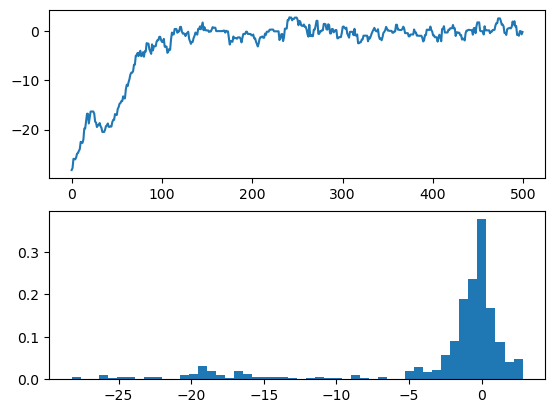

Accept ratio = 0.7082


In [61]:
# Warm up
thetas, accept_ratio = mh_sample(-30.0, 10000,
                                 lambda theta: -np.abs(theta),
                                 lambda theta_t: theta_t + np.random.randn())

fig, ax = plt.subplots(2)

ax[0].plot(thetas[:500])  
ax[1].hist(thetas[:500], bins=50, density=True)

plt.show()

print("Accept ratio =", accept_ratio)

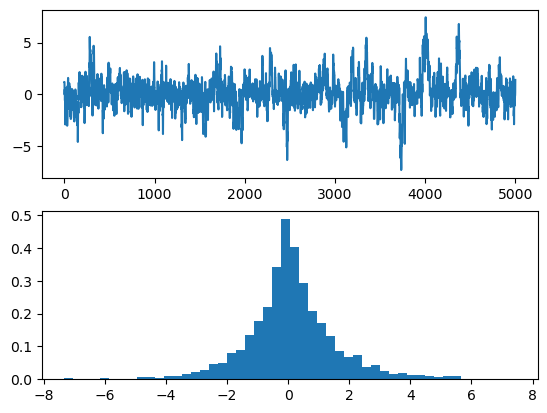

In [62]:
fig, ax = plt.subplots(2)

ax[0].plot(thetas[len(thetas)//2:])   # discard the first half
ax[1].hist(thetas[len(thetas)//2:], bins=50, density=True)

plt.show()

<div class="alert alert-success">
    
**Exercise**. Run Metropolis-Hastings to sample from a mixture of two Gaussians.
    
</div>

<div class="alert alert-success">
    
**Exercise**. Run Metropolis-Hastings to sample from a density $\pi(\theta) = \frac{1}{Z} \theta^2$ supported on $[-1, 1]$.
</div>

# Bayesian inference with MCMC

In [63]:
# Generative model
theta_true = np.array([-3.0, 0.0, np.log(5.0)])

def generate(n_samples, theta_true):
    x = np.random.rand(n_samples) * 20 - 10
    x = np.sort(x)
    
    y = theta_true[0] * x + theta_true[1] + np.random.randn(n_samples) * np.exp(theta_true[2])
    
    return x, y

In [71]:
x, y = generate(5, theta_true)
# y[-1] = y[-1] + 100  # add an outlier

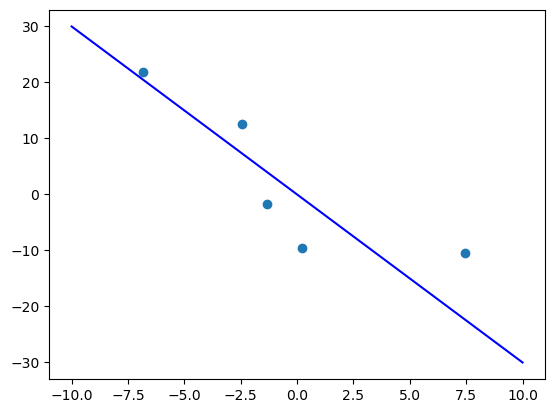

In [72]:
fig = plt.figure()
ax = plt.axes()
ax.scatter(x, y)
xs = np.linspace(-10, 10)
ax.plot(xs, theta_true[0] * xs + theta_true[1], color="blue")
plt.show()

In [73]:
# Sampling the posterior
from scipy.stats import norm, multivariate_normal, laplace

def log_likelihood(theta, x, y):
    return norm.logpdf(y, loc=theta[0] * x + theta[1], scale=np.exp(theta[2])).sum()
    #return laplace.logpdf(y, loc=theta[0] * x + theta[1], scale=np.exp(theta[2])).sum()

def log_prior(theta):   
    return (norm.logpdf(theta[0], loc=0., scale=3) + 
            norm.logpdf(theta[1], loc=0., scale=3) +
            norm.logpdf(theta[2], loc=np.log(1.0), scale=3))

def log_posterior(theta, x, y):
    return log_likelihood(theta, x, y) + log_prior(theta) # -normalizing constant (not needed!)

In [74]:
thetas, accept_ratio = mh_sample(np.array([0.0, 0.0, 0.0]), 50000,
                                 lambda theta: log_posterior(theta, x, y),
                                 lambda theta_t: theta_t + multivariate_normal.rvs(mean=[0.0, 0.0, 0.0], cov=0.1))

print("Accept ratio =", accept_ratio)

100%|██████████| 50000/50000 [00:32<00:00, 1535.00it/s]

Accept ratio = 0.65818


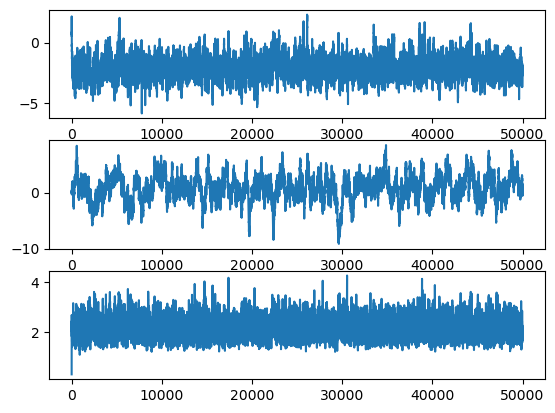

In [75]:
fig, ax = plt.subplots(3)

for i in range(3):
    ax[i].plot(thetas[:, i])

plt.show()

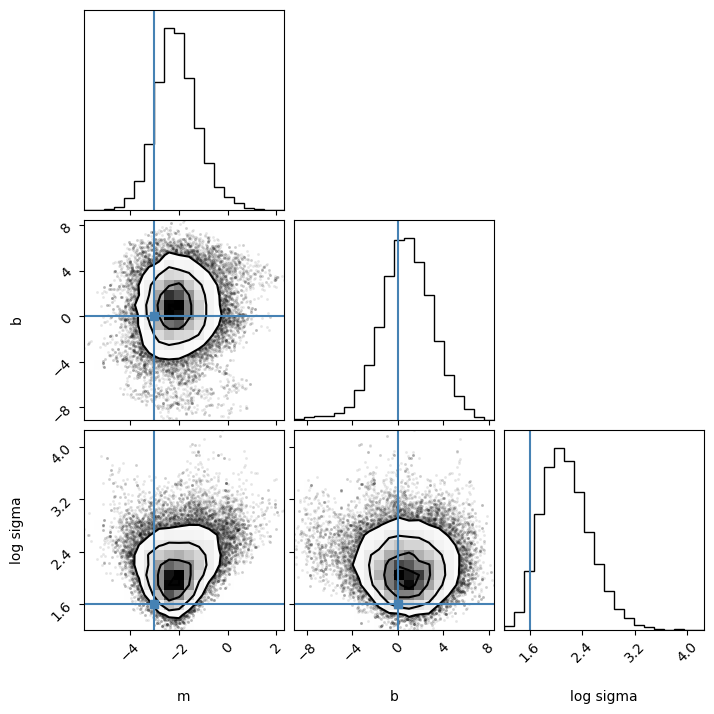

In [76]:
import corner
fig = corner.corner(thetas[1000:], labels=["m", "b", "log sigma"], truths=theta_true)

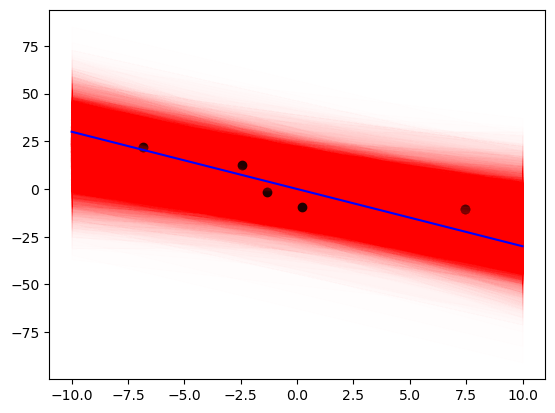

In [83]:
fig = plt.figure()
ax = plt.axes()
ax.scatter(x, y)
xs = np.linspace(-10, 10)
warmup = 1000

for i in range(1000):
    ax.plot(xs, thetas[warmup+i, 0] * xs + thetas[warmup+i, 1], color="red", alpha=0.01)
    ax.fill_between(xs, 
                    thetas[warmup+i, 0] * xs + thetas[warmup+i, 1] - 2*np.exp(thetas[warmup+i, 2]), 
                    thetas[warmup+i, 0] * xs + thetas[warmup+i, 1] + 2*np.exp(thetas[warmup+i, 2]), 
                    color="red", alpha=0.0025)

ax.plot(xs, theta_true[0] * xs + theta_true[1], color="blue")
#ax.set(ylim=(-50,50))
plt.show()

<div class="alert alert-success">
    
**Exercise**. Repeat with fewer observations. What do you observe?
    
</div>

# `emcee`

In [85]:
import emcee

pos = np.array([0.0, 0.0, 0.0]) + 0.1 * np.random.randn(10, 3)
nwalkers, ndim = pos.shape

In [86]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=(x, y))
sampler.run_mcmc(pos, 100000 // nwalkers, progress=True);

100%|██████████| 10000/10000 [00:26<00:00, 378.21it/s]


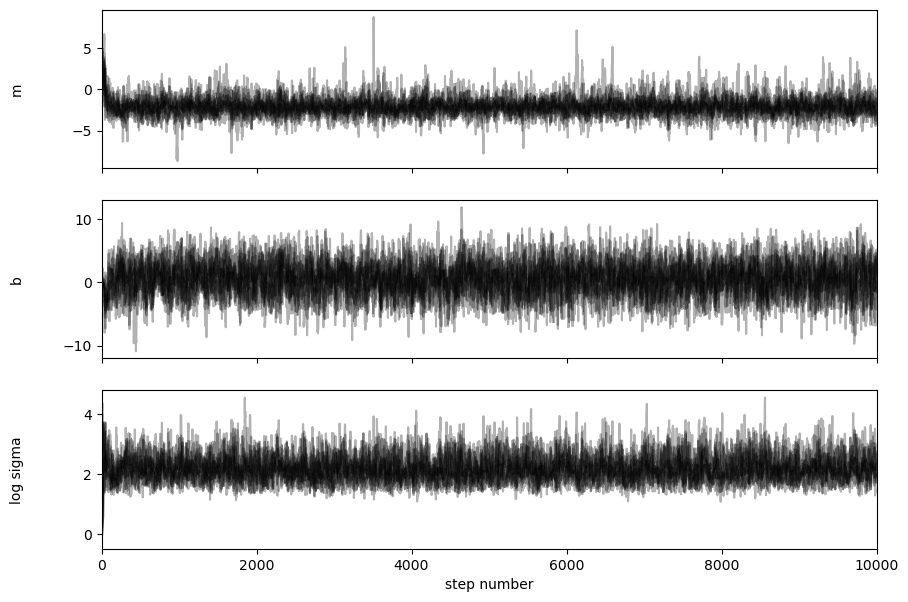

In [87]:
fig, axes = plt.subplots(ndim, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["m", "b", "log sigma"]

for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number")
plt.show()

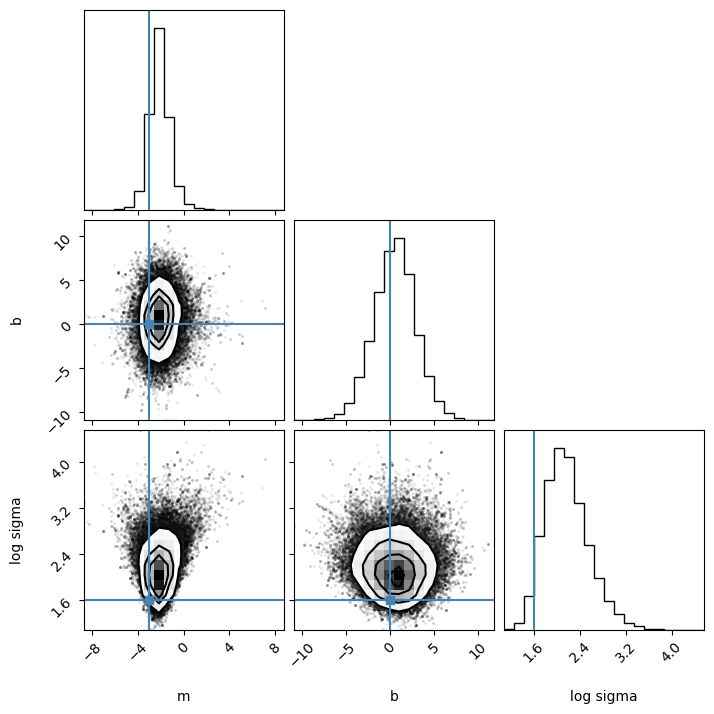

In [91]:
import corner
thetas = sampler.get_chain(flat=True, discard=200)
fig = corner.corner(thetas, labels=labels, truths=theta_true)

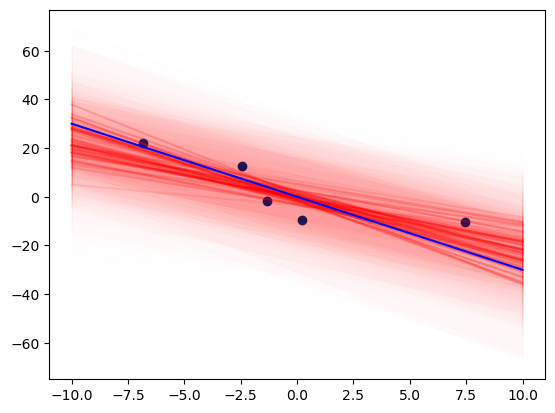

In [92]:
fig = plt.figure()
ax = plt.axes()
ax.scatter(x, y)
xs = np.linspace(-10, 10)
warmup = 1000

for i in range(100):
    ax.plot(xs, thetas[warmup+i, 0] * xs + thetas[warmup+i, 1], color="red", alpha=0.1)
    ax.fill_between(xs, 
                    thetas[warmup+i, 0] * xs + thetas[warmup+i, 1] - 2*np.exp(thetas[warmup+i, 2]), 
                    thetas[warmup+i, 0] * xs + thetas[warmup+i, 1] + 2*np.exp(thetas[warmup+i, 2]), 
                    color="red", alpha=0.002)

ax.plot(xs, theta_true[0] * xs + theta_true[1], color="blue")
plt.show()

In [90]:
tau = sampler.get_autocorr_time()
tau

array([43.02663204, 35.71625334, 46.65868152])